# Import necessary libraries

In [1]:
# Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
# libaries to help with data visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

#Library for missing values
import missingno as msno

# Library to split data
from sklearn.model_selection import train_test_split
# library to import to standardize the data
from sklearn.preprocessing import MinMaxScaler
#To import different metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error, make_scorer
#Importing classback API
from keras import callbacks
# Importing tensorflow library
import tensorflow as tf

# importing different functions to build models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout,InputLayer, Input
from tensorflow.keras.models import Sequential
# Importing Batch Normalization
from keras.layers import BatchNormalization
# Importing backend
from tensorflow.keras import backend
# Importing shffule
import random
from random import shuffle
from keras.callbacks import ModelCheckpoint
# Importing optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from  tensorflow.keras.optimizers import SGD

#Gridsearch for hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.neural_network import MLPRegressor
import scikeras
from scikeras.wrappers import KerasRegressor

#Import Shap
import shap

# Library to avoid the warnings
import warnings
warnings.filterwarnings("ignore")

# Data loading & overview 

In [2]:
All = pd.ExcelFile('allData.xls')
data = pd.read_excel(All, 'Data')
data

Number          Data source Selected Mix number in literature  \
0        NaN       2. Yunusa 2014      NaN                    PC-40   
1        NaN       2. Yunusa 2014      NaN                    PC-50   
2        NaN       2. Yunusa 2014      NaN                    PC-60   
3        NaN       2. Yunusa 2014      NaN                    PC-75   
4        NaN       2. Yunusa 2014      NaN                    FA-40   
...      ...                  ...      ...                      ...   
1983     NaN  J48. Farahani, 2015      NaN                     W3-4   
1984     NaN  J48. Farahani, 2015      NaN                     W4-1   
1985     NaN  J48. Farahani, 2015      NaN                     W4-2   
1986     NaN  J48. Farahani, 2015      NaN                     W4-3   
1987     NaN  J48. Farahani, 2015      NaN                     W4-4   

      ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
0                                                   0.0       
1                                                   0.0       
2                                                   0.0       
3                                                   0.0       
4                                                   0.0       
...                                                 ...       
1983                                              350.0       
1984                                              380.0       
1985                                              370.0       
1986                                              360.0       
1987                                              350.0       

      CEM I 42.5N ordinary Portland Cement content (kg/m^3)  \
0                                                   0.0       
1                                                   0.0       
2                                                   0.0       
3                                                   0.0       
4                                                   0.0       
...                                                 ...       
1983                                                0.0       
1984                                                0.0       
1985                                                0.0       
1986                                                0.0       
1987                                                0.0       

      CEM I 52.5N ordinary Portland Cement content (kg/m^3)  \
0                                                 450.0       
1                                                 400.0       
2                                                 350.0       
3                                                 300.0       
4                                                 315.0       
...                                                 ...       
1983                                                0.0       
1984                                                0.0       
1985                                                0.0       
1986                                                0.0       
1987                                                0.0       

      Class C Fly ash content (kg/m^3)  Class F Fly ash content (kg/m^3)  \
0                                  0.0                               0.0   
1                                  0.0                               0.0   
2                                  0.0                               0.0   
3                                  0.0                               0.0   
4                                  0.0                             135.0   
...                                ...                               ...   
1983                               0.0                               0.0   
1984                               0.0                               0.0   
1985                               0.0                               0.0   
1986                               0.0                               0.0   
1987                               0.0        

In [3]:
data.isnull().sum()

Number                                                                1988
Data source                                                              0
Selected                                                              1794
Mix number in literature                                                 0
ASTM type 1 ordinary Portland Cement content (kg/m^3)                    0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)                    0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)                    0
Class C Fly ash content (kg/m^3)                                         0
Class F Fly ash content (kg/m^3)                                         0
Slag content (kg/m^3)                                                    0
Silica fume content (kg/m^3)                                             0
Water content (kg/m^3)                                                   0
Superplasticizer content (kg/m^3)                                        0
Maximum coarse aggregate 

In [4]:
Excess_col_indices = [0] + list(range(2, 4)) + list(range(20, 27)) + [33]
semi_df = data.iloc[:, [col for col in range(data.shape[1]) if col not in Excess_col_indices]]
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1988 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 6   Slag content (kg/m^3)                                  1988 non-null   float64
 7   Silica fume content (kg/m^3)                           1988 non-null   float64
 8   Water content (kg/m^3)                          

# Quick fix on the compressive strength and use converted strength

In [5]:
filtered_row = semi_df[semi_df['Average 28-day compressive strength (Mpa)'] > 400]

if len(filtered_row) == 1:
    value_to_divide = filtered_row['Average 28-day compressive strength (Mpa)'].values[0]
    updated_value = value_to_divide / 10

    # Update the value in the DataFrame
    semi_df.loc[semi_df['Average 28-day compressive strength (Mpa)'] > 400, 'Average 28-day compressive strength (Mpa)'] = updated_value
else:
    print("No rows or multiple rows matching the condition.")

In [6]:
semi_df.describe().T

count         mean  \
ASTM type 1 ordinary Portland Cement content (k...  1988.0    39.317656   
CEM I 42.5N ordinary Portland Cement content (k...  1988.0    95.567020   
CEM I 52.5N ordinary Portland Cement content (k...  1988.0   147.092807   
Class C Fly ash content (kg/m^3)                    1988.0     6.120221   
Class F Fly ash content (kg/m^3)                    1988.0    35.497918   
Slag content (kg/m^3)                               1988.0    34.629970   
Silica fume content (kg/m^3)                        1988.0     7.592819   
Water content (kg/m^3)                              1988.0   172.241112   
Superplasticizer content (kg/m^3)                   1988.0     2.335606   
Maximum coarse aggregate size (mm)                  1988.0    18.122485   
Coarse aggregate content (kg/m^3)                   1983.0  1005.263947   
Fine aggregate content (kg/m^3)                     1983.0   814.084454   
Curing temperature (Celsius degree)                 1980.0    21.535354   
Curing humidity (%)                                 1980.0    95.006566   
Curing day                                          1978.0    25.849343   
Slump (mm)                                           820.0   105.309756   
Average 28-day compressive strength (Mpa)           1942.0    51.340071   
Average 28-day split strength (Mpa)                   62.0     3.679032   
Chloride diffusion coefficient (10-12 m2/s)           66.0     5.239591   
Average carbonation coefficient (mm/year^0.5)       1095.0     3.718963   

                                                           std     min  \
ASTM type 1 ordinary Portland Cement content (k...  106.825528    0.00   
CEM I 42.5N ordinary Portland Cement content (k...  146.591457    0.00   
CEM I 52.5N ordinary Portland Cement content (k...  152.375401    0.00   
Class C Fly ash content (kg/m^3)                     28.791545    0.00   
Class F Fly ash content (kg/m^3)                     65.744896    0.00   
Slag content (kg/m^3)                                73.837709    0.00   
Silica fume content (kg/m^3)                         21.082168    0.00   
Water content (kg/m^3)                               28.371606  105.00   
Superplasticizer content (kg/m^3)                     4.726357    0.00   
Maximum coarse aggregate size (mm)                    3.828674    9.50   
Coarse aggregate content (kg/m^3)                   163.277663  276.00   
Fine aggregate content (kg/m^3)                     142.479664  279.00   
Curing temperature (Celsius degree)                   2.892248   13.00   
Curing humidity (%)                                  12.285983   25.00   
Curing day                                           23.381716    1.00   
Slump (mm)                                           57.098701    0.00   
Average 28-day compressive strength (Mpa)            18.930602    5.00   
Average 28-day split strength (Mpa)                   1.113884    0.96   
Chloride diffusion coefficient (10-12 m2/s)           6.094627    0.50   
Average carbonation coefficient (mm/year^0.5)         2.691309    0.00   

                                                           25%          50%  \
ASTM type 1 ordinary Portland Cement content (k...    0.000000     0.000000   
CEM I 42.5N ordinary Portland Cement content (k...    0.000000     0.000000   
CEM I 52.5N ordinary Portland Cement content (k...    0.000000   155.000000   
Class C Fly ash content (kg/m^3)                      0.000000     0.000000   
Class F Fly ash content (kg/m^3)                      0.000000     0.000000   
Slag content (kg/m^3)                                 0.000000     0.000000   
Silica fume content (kg/m^3)                          0.000000     0.000000   
Water content (kg/m^3)                              153.000000   170.000000   
Superplasticizer content (kg/m^3)                     0.000000     0.000000   
Maximum coarse aggregate size (mm)                   16.000000    20.000000   
Coarse aggregate content (kg/m^3)                   8

In [7]:
## Conversion with specimen size
# Follow the same conversion factor from Compressive strength.ipynb
conversion_factors = {
    '150*150*150': 1.0,
    '200h*100r': {
        (15, 44): 1.21,
        (45, 54): 1.17,
        (55, 64): 1.12,
        (65, 74): 1.10,
        (75, 84): 1.08,
        (85, 94): 1.06,
        (95, 104): 1.04,  # Guess, out of range
        (105, 114): 1.02,
    },
    '100*100*100': 0.95,
    '100*100*300': {},  # No suitable conversion index available
    '300h*150r': {
        (15, 44): 1.32,
        (45, 54): 1.32,
        (55, 64): 1.28,
        (65, 74): 1.25,
        (75, 84): 1.22,
        (85, 94): 1.19,
        (95, 104): 1.16,
        (105, 114): 1.13,
    },
    '100h*100r': {},  # No suitable conversion index available
}


def convert_strength(row):
    size = row['Specimen size']
    strength = row['Average 28-day compressive strength (Mpa)']

    original_size = size  # Store the original size

    if size in conversion_factors:
        factor = conversion_factors[size]

        if isinstance(factor, dict):
            for range_, conversion_factor in factor.items():
                lower_bound, upper_bound = range_
                if lower_bound <= strength < upper_bound:
                    return strength * conversion_factor
        else:
            return strength * factor

    return strength


# Apply the conversion function to the DataFrame
semi_df['Converted Strength'] = semi_df.apply(convert_strength, axis=1)

# Print the updated DataFrame
print(semi_df)

              Data source  \
0          2. Yunusa 2014   
1          2. Yunusa 2014   
2          2. Yunusa 2014   
3          2. Yunusa 2014   
4          2. Yunusa 2014   
...                   ...   
1983  J48. Farahani, 2015   
1984  J48. Farahani, 2015   
1985  J48. Farahani, 2015   
1986  J48. Farahani, 2015   
1987  J48. Farahani, 2015   

      ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
0                                                   0.0       
1                                                   0.0       
2                                                   0.0       
3                                                   0.0       
4                                                   0.0       
...                                                 ...       
1983                                              350.0       
1984                                              380.0       
1985                                              370.0       
1986                 

In [8]:
semi_df['Converted Strength']

0       75.93
1       64.50
2       49.23
3       36.00
4       62.80
        ...  
1983      NaN
1984      NaN
1985      NaN
1986      NaN
1987      NaN
Name: Converted Strength, Length: 1988, dtype: float64

In [9]:
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 24 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1988 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 6   Slag content (kg/m^3)                                  1988 non-null   float64
 7   Silica fume content (kg/m^3)                           1988 non-null   float64
 8   Water content (kg/m^3)                          

In [10]:
semi_df = semi_df.drop(['Average 28-day compressive strength (Mpa)', 'Specimen size', 'Curing humidity (%)'], axis = 1)
semi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1988 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1988 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1988 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1988 non-null   float64
 6   Slag content (kg/m^3)                                  1988 non-null   float64
 7   Silica fume content (kg/m^3)                           1988 non-null   float64
 8   Water content (kg/m^3)                          

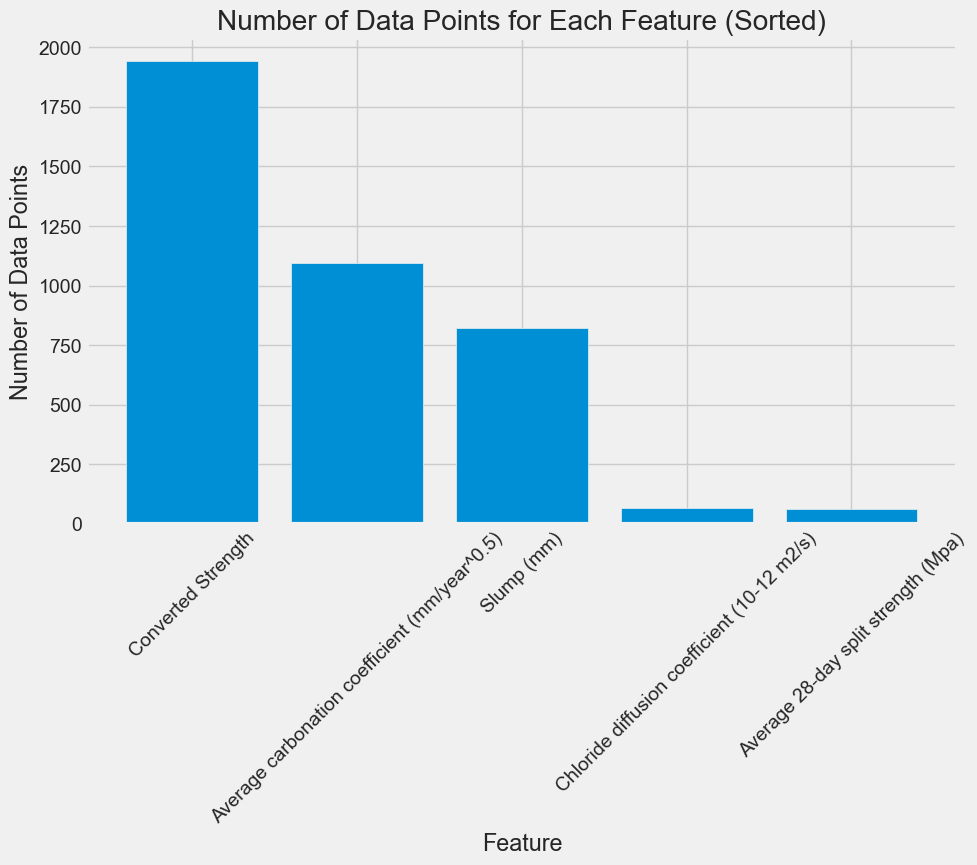

In [11]:
# Subset the DataFrame with the columns of interest
subset_df = semi_df[['Slump (mm)', 'Average 28-day split strength (Mpa)',
                     'Chloride diffusion coefficient (10-12 m2/s)',
                     'Average carbonation coefficient (mm/year^0.5)',
                     'Converted Strength']]

# Calculate the number of data points for each feature
counts = subset_df.count()

# Sort the counts in descending order
sorted_counts = counts.sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_counts.index, sorted_counts.values)

# Set plot labels and title
plt.xlabel('Feature')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Feature (Sorted)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Curing method

In [12]:
missing = semi_df['Curing method'].isnull()
semi_df[missing]

Data source  \
1946  J45. Kayali, 2012   
1947  J45. Kayali, 2012   
1948  J45. Kayali, 2012   
1949  J45. Kayali, 2012   
1950  J45. Kayali, 2012   
1951  J45. Kayali, 2012   
1952  J45. Kayali, 2012   
1953  J45. Kayali, 2012   

      ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
1946                                                0.0       
1947                                                0.0       
1948                                                0.0       
1949                                                0.0       
1950                                                0.0       
1951                                                0.0       
1952                                                0.0       
1953                                                0.0       

      CEM I 42.5N ordinary Portland Cement content (kg/m^3)  \
1946                                              450.0       
1947                                              405.0       
1948                                              337.5       
1949                                              292.5       
1950                                              225.0       
1951                                              180.0       
1952                                              135.0       
1953                                               90.0       

      CEM I 52.5N ordinary Portland Cement content (kg/m^3)  \
1946                                                0.0       
1947                                                0.0       
1948                                                0.0       
1949                                                0.0       
1950                                                0.0       
1951                                                0.0       
1952                                                0.0       
1953                                                0.0       

      Class C Fly ash content (kg/m^3)  Class F Fly ash content (kg/m^3)  \
1946                               0.0                               0.0   
1947                               0.0                               0.0   
1948                               0.0                               0.0   
1949                               0.0                               0.0   
1950                               0.0                               0.0   
1951                               0.0                               0.0   
1952                               0.0                               0.0   
1953                               0.0                               0.0   

      Slag content (kg/m^3)  Silica fume content (kg/m^3)  \
1946                    0.0                           0.0   
1947                    0.0                          45.0   
1948                  112.5                           0.0   
1949                  112.5                          45.0   
1950                  225.0                           0.0   
1951                  225.0                          45.0   
1952                  315.0                           0.0   
1953                  315.0                          45.0   

      Water content (kg/m^3)  Superplasticizer content (kg/m^3)  ...  \
1946                   171.0                              5.130  ...   
1947                   171.0                              5.850  ...   
1948                   171.0                              5.850  ...   
1949                   171.0                              5.895  ...   
1950                   171.0                              5.400  ...   
1951                   171.0                              5.850  ...   
1952                   171.0                              4.230  ...   
1953                   171.0                              5.850  ...   

      Coarse aggregate content (kg/m^3)  Fine aggregate content (kg/m^3)  \
1946                             1110.0                            680.0   
1947                        

In [13]:
semi_df = semi_df.dropna(subset = ['Curing method'])
new_df = semi_df.copy()
new_df = pd.concat([semi_df, pd.get_dummies(semi_df['Curing method'])], axis=1)
new_df.isnull().sum()

Data source                                                 0
ASTM type 1 ordinary Portland Cement content (kg/m^3)       0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)       0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)       0
Class C Fly ash content (kg/m^3)                            0
Class F Fly ash content (kg/m^3)                            0
Slag content (kg/m^3)                                       0
Silica fume content (kg/m^3)                                0
Water content (kg/m^3)                                      0
Superplasticizer content (kg/m^3)                           0
Maximum coarse aggregate size (mm)                          0
Coarse aggregate content (kg/m^3)                           5
Fine aggregate content (kg/m^3)                             5
Curing method                                               0
Curing temperature (Celsius degree)                         0
Curing day                                                  2
Slump (m

In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 25 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1980 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 6   Slag content (kg/m^3)                                  1980 non-null   float64
 7   Silica fume content (kg/m^3)                           1980 non-null   float64
 8   Water content (kg/m^3)                          

In [15]:
new_df = new_df.drop(['Curing method', 'Curing day'], axis= 1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 23 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1980 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 6   Slag content (kg/m^3)                                  1980 non-null   float64
 7   Silica fume content (kg/m^3)                           1980 non-null   float64
 8   Water content (kg/m^3)                          

# Data preparation

In [16]:
new_df = new_df.drop(['Average 28-day split strength (Mpa)', 'Chloride diffusion coefficient (10-12 m2/s)'], axis = 1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 0 to 1987
Data columns (total 21 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Data source                                            1980 non-null   object 
 1   ASTM type 1 ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 2   CEM I 42.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 3   CEM I 52.5N ordinary Portland Cement content (kg/m^3)  1980 non-null   float64
 4   Class C Fly ash content (kg/m^3)                       1980 non-null   float64
 5   Class F Fly ash content (kg/m^3)                       1980 non-null   float64
 6   Slag content (kg/m^3)                                  1980 non-null   float64
 7   Silica fume content (kg/m^3)                           1980 non-null   float64
 8   Water content (kg/m^3)                          

## Drop na

In [17]:
new_df_drop = new_df.dropna()
new_df_drop.isnull().sum()

Data source                                              0
ASTM type 1 ordinary Portland Cement content (kg/m^3)    0
CEM I 42.5N ordinary Portland Cement content (kg/m^3)    0
CEM I 52.5N ordinary Portland Cement content (kg/m^3)    0
Class C Fly ash content (kg/m^3)                         0
Class F Fly ash content (kg/m^3)                         0
Slag content (kg/m^3)                                    0
Silica fume content (kg/m^3)                             0
Water content (kg/m^3)                                   0
Superplasticizer content (kg/m^3)                        0
Maximum coarse aggregate size (mm)                       0
Coarse aggregate content (kg/m^3)                        0
Fine aggregate content (kg/m^3)                          0
Curing temperature (Celsius degree)                      0
Slump (mm)                                               0
Average carbonation coefficient (mm/year^0.5)            0
Converted Strength                                      

In [18]:
new_df_drop.describe().T

count         mean  \
ASTM type 1 ordinary Portland Cement content (k...  505.0     0.000000   
CEM I 42.5N ordinary Portland Cement content (k...  505.0    69.551089   
CEM I 52.5N ordinary Portland Cement content (k...  505.0   197.544554   
Class C Fly ash content (kg/m^3)                    505.0     2.700990   
Class F Fly ash content (kg/m^3)                    505.0    39.486931   
Slag content (kg/m^3)                               505.0    34.752079   
Silica fume content (kg/m^3)                        505.0     3.251980   
Water content (kg/m^3)                              505.0   175.081208   
Superplasticizer content (kg/m^3)                   505.0     0.864601   
Maximum coarse aggregate size (mm)                  505.0    18.912871   
Coarse aggregate content (kg/m^3)                   505.0  1078.545457   
Fine aggregate content (kg/m^3)                     505.0   804.334939   
Curing temperature (Celsius degree)                 505.0    21.588119   
Slump (mm)                                          505.0   106.166337   
Average carbonation coefficient (mm/year^0.5)       505.0     4.544174   
Converted Strength                                  505.0    52.475635   
Air                                                 505.0     0.025743   
Moist                                               505.0     0.530693   
Sealed                                              505.0     0.059406   
Submerged                                           505.0     0.384158   

                                                           std         min  \
ASTM type 1 ordinary Portland Cement content (k...    0.000000    0.000000   
CEM I 42.5N ordinary Portland Cement content (k...  123.663744    0.000000   
CEM I 52.5N ordinary Portland Cement content (k...  136.984533    0.000000   
Class C Fly ash content (kg/m^3)                     15.443146    0.000000   
Class F Fly ash content (kg/m^3)                     57.978862    0.000000   
Slag content (kg/m^3)                                67.452487    0.000000   
Silica fume content (kg/m^3)                         10.675975    0.000000   
Water content (kg/m^3)                               25.050504  129.000000   
Superplasticizer content (kg/m^3)                     1.561394    0.000000   
Maximum coarse aggregate size (mm)                    4.614970   10.000000   
Coarse aggregate content (kg/m^3)                   117.765327  908.000000   
Fine aggregate content (kg/m^3)                     108.280733  449.000000   
Curing temperature (Celsius degree)                   3.373663   20.000000   
Slump (mm)                                           53.516057   10.000000   
Average carbonation coefficient (mm/year^0.5)         2.964080    0.017261   
Converted Strength                                   16.594796    9.000000   
Air                                                   0.158523    0.000000   
Moist                                                 0.499552    0.000000   
Sealed                                                0.236617    0.000000   
Submerged                                             0.486878    0.000000   

                                                        25%       50%  \
ASTM type 1 ordinary Portland Cement content (k...    0.000     0.000   
CEM I 42.5N ordinary Portland Cement content (k...    0.000     0.000   
CEM I 52.5N ordinary Portland Cement content (k...    0.000   217.000   
Class C Fly ash content (kg/m^3)                      0.000     0.000   
Class F Fly ash content (kg/m^3)                      0.000     0.000   
Slag content (kg/m^3)                                 0.000     0.000   
Silica fume content (kg/m^3)                          0.000     0.000   
Water content (kg/m^3)                              155.000   180.000   
Superplasticizer content (kg/m^3)                     0.000     0.000   
Maximum coarse aggregate size (mm)                   16.000    20.000   
Coarse aggregate content (kg/m^3)                   990

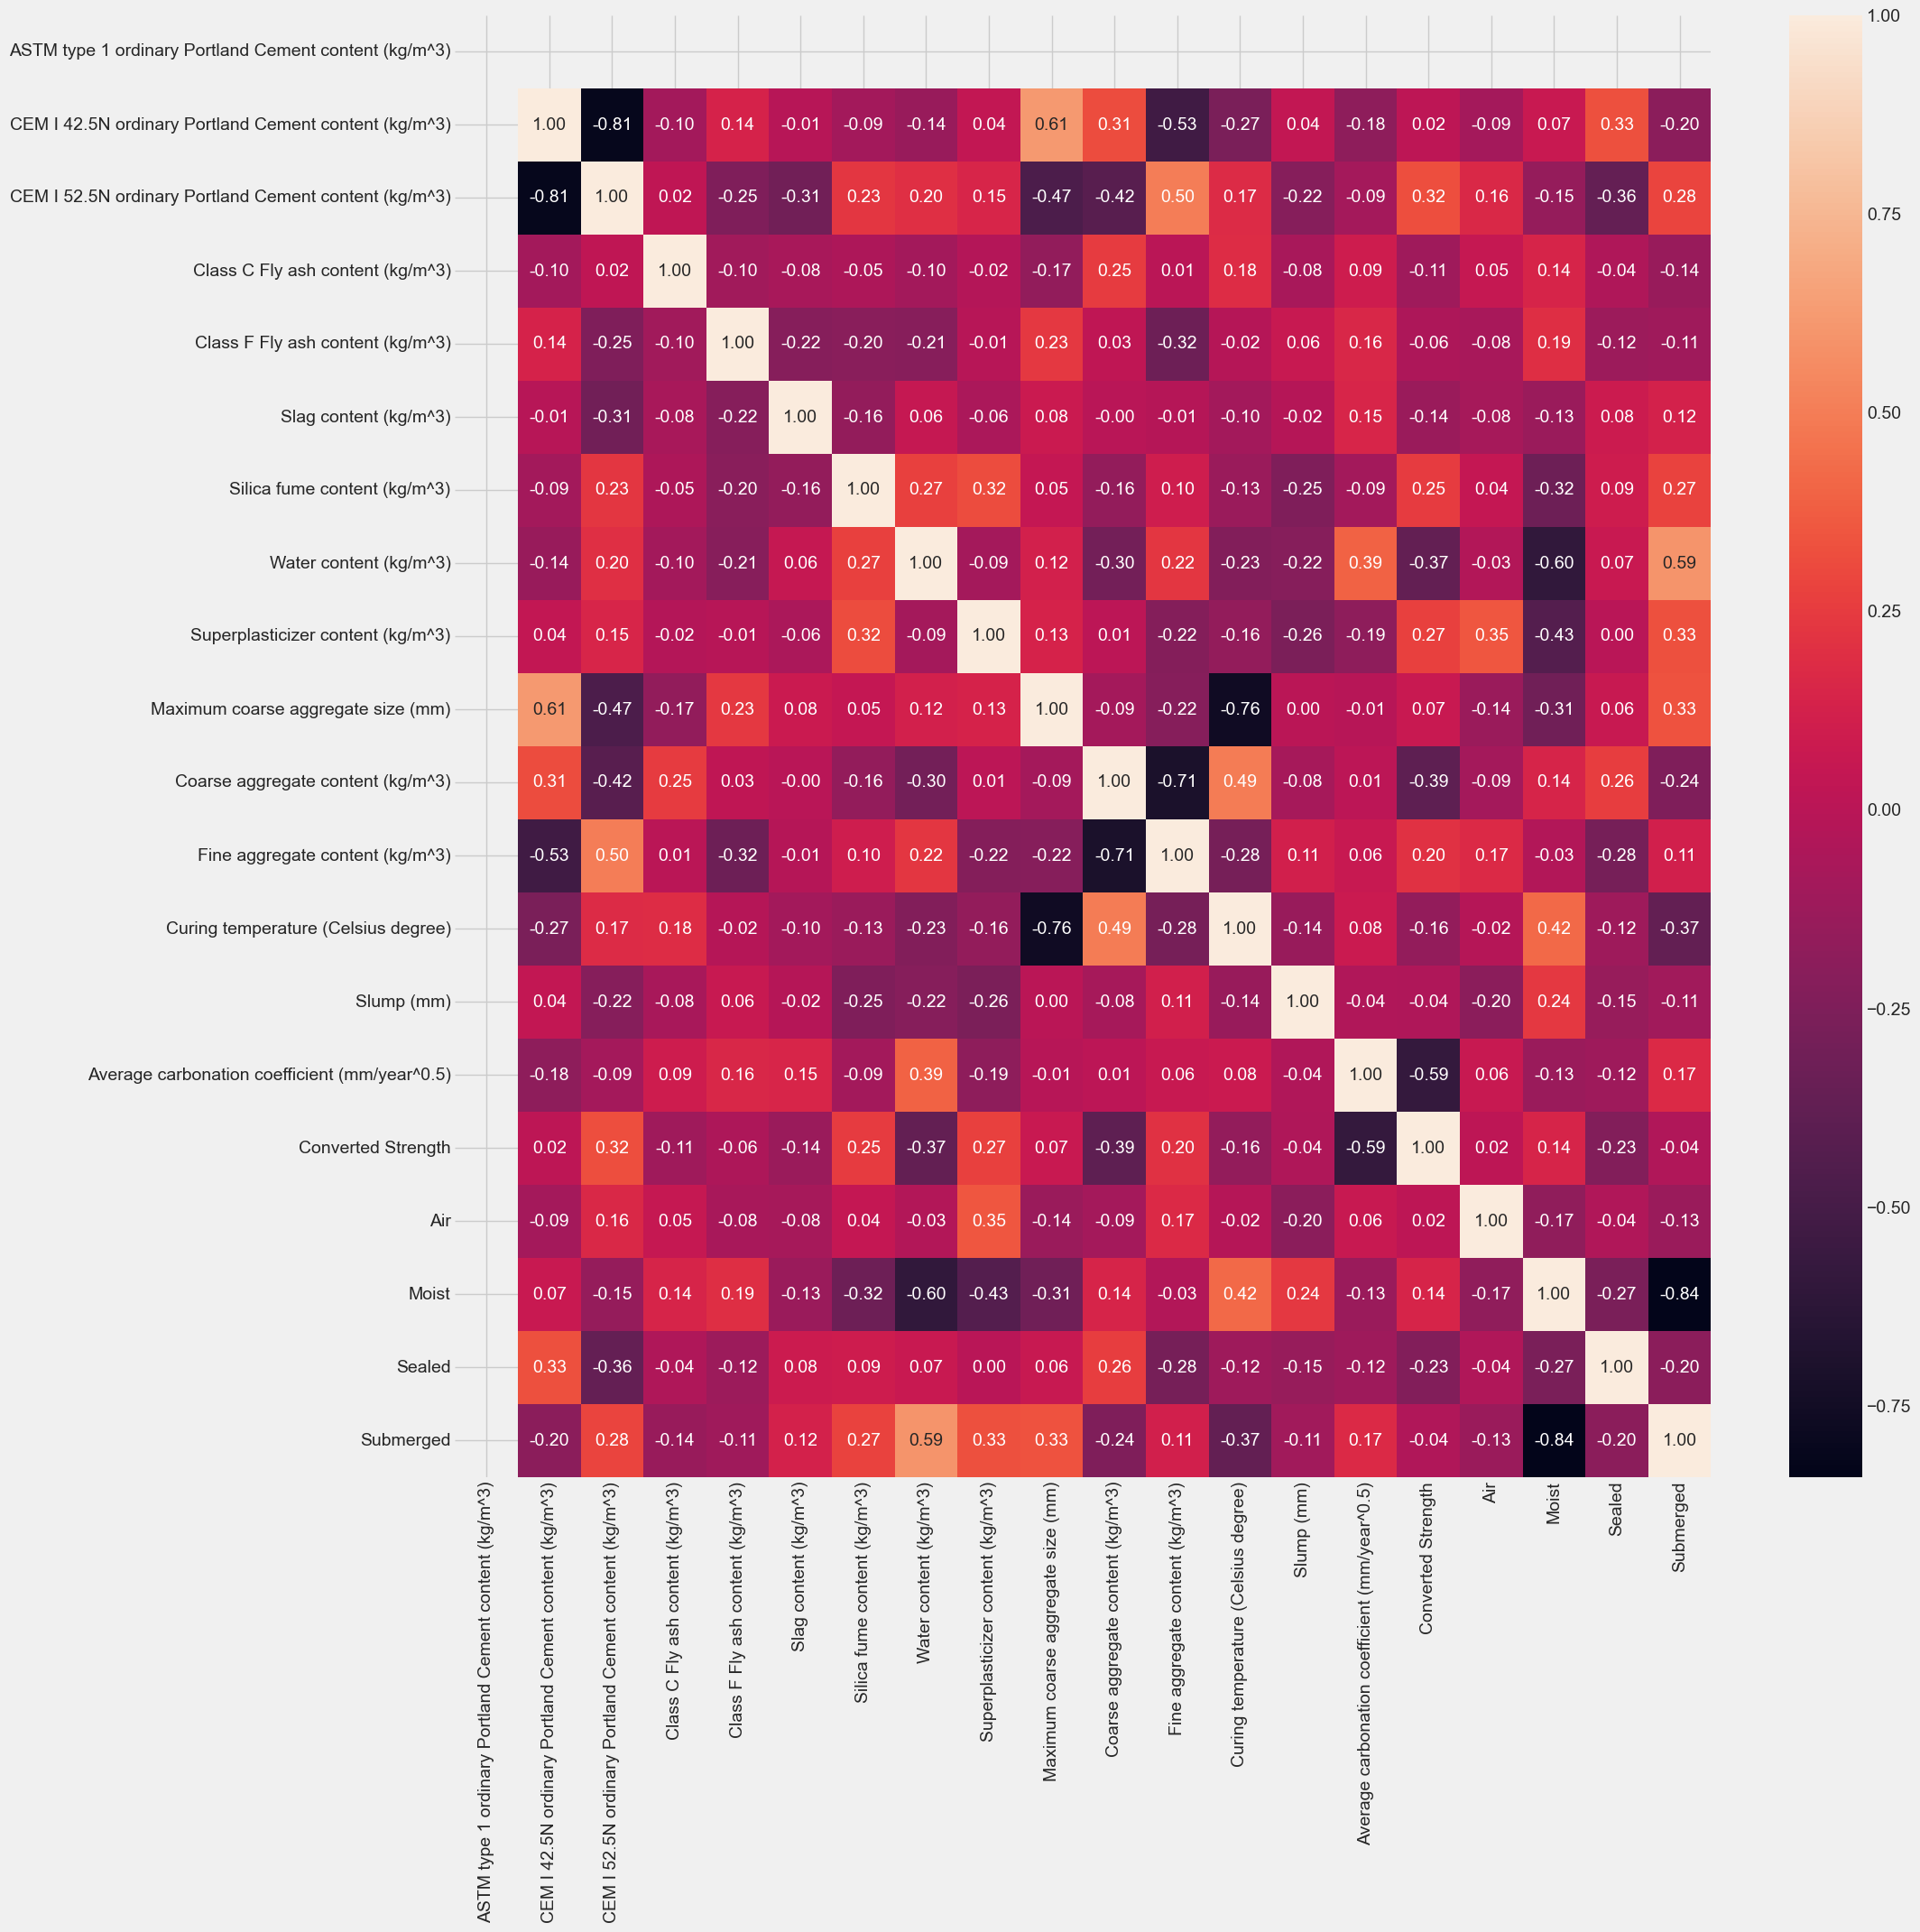

In [19]:
plt.figure(figsize=(20,20))
sns.heatmap(new_df_drop.corr(), annot= True, fmt='.2f', cmap='rocket')
plt.show()

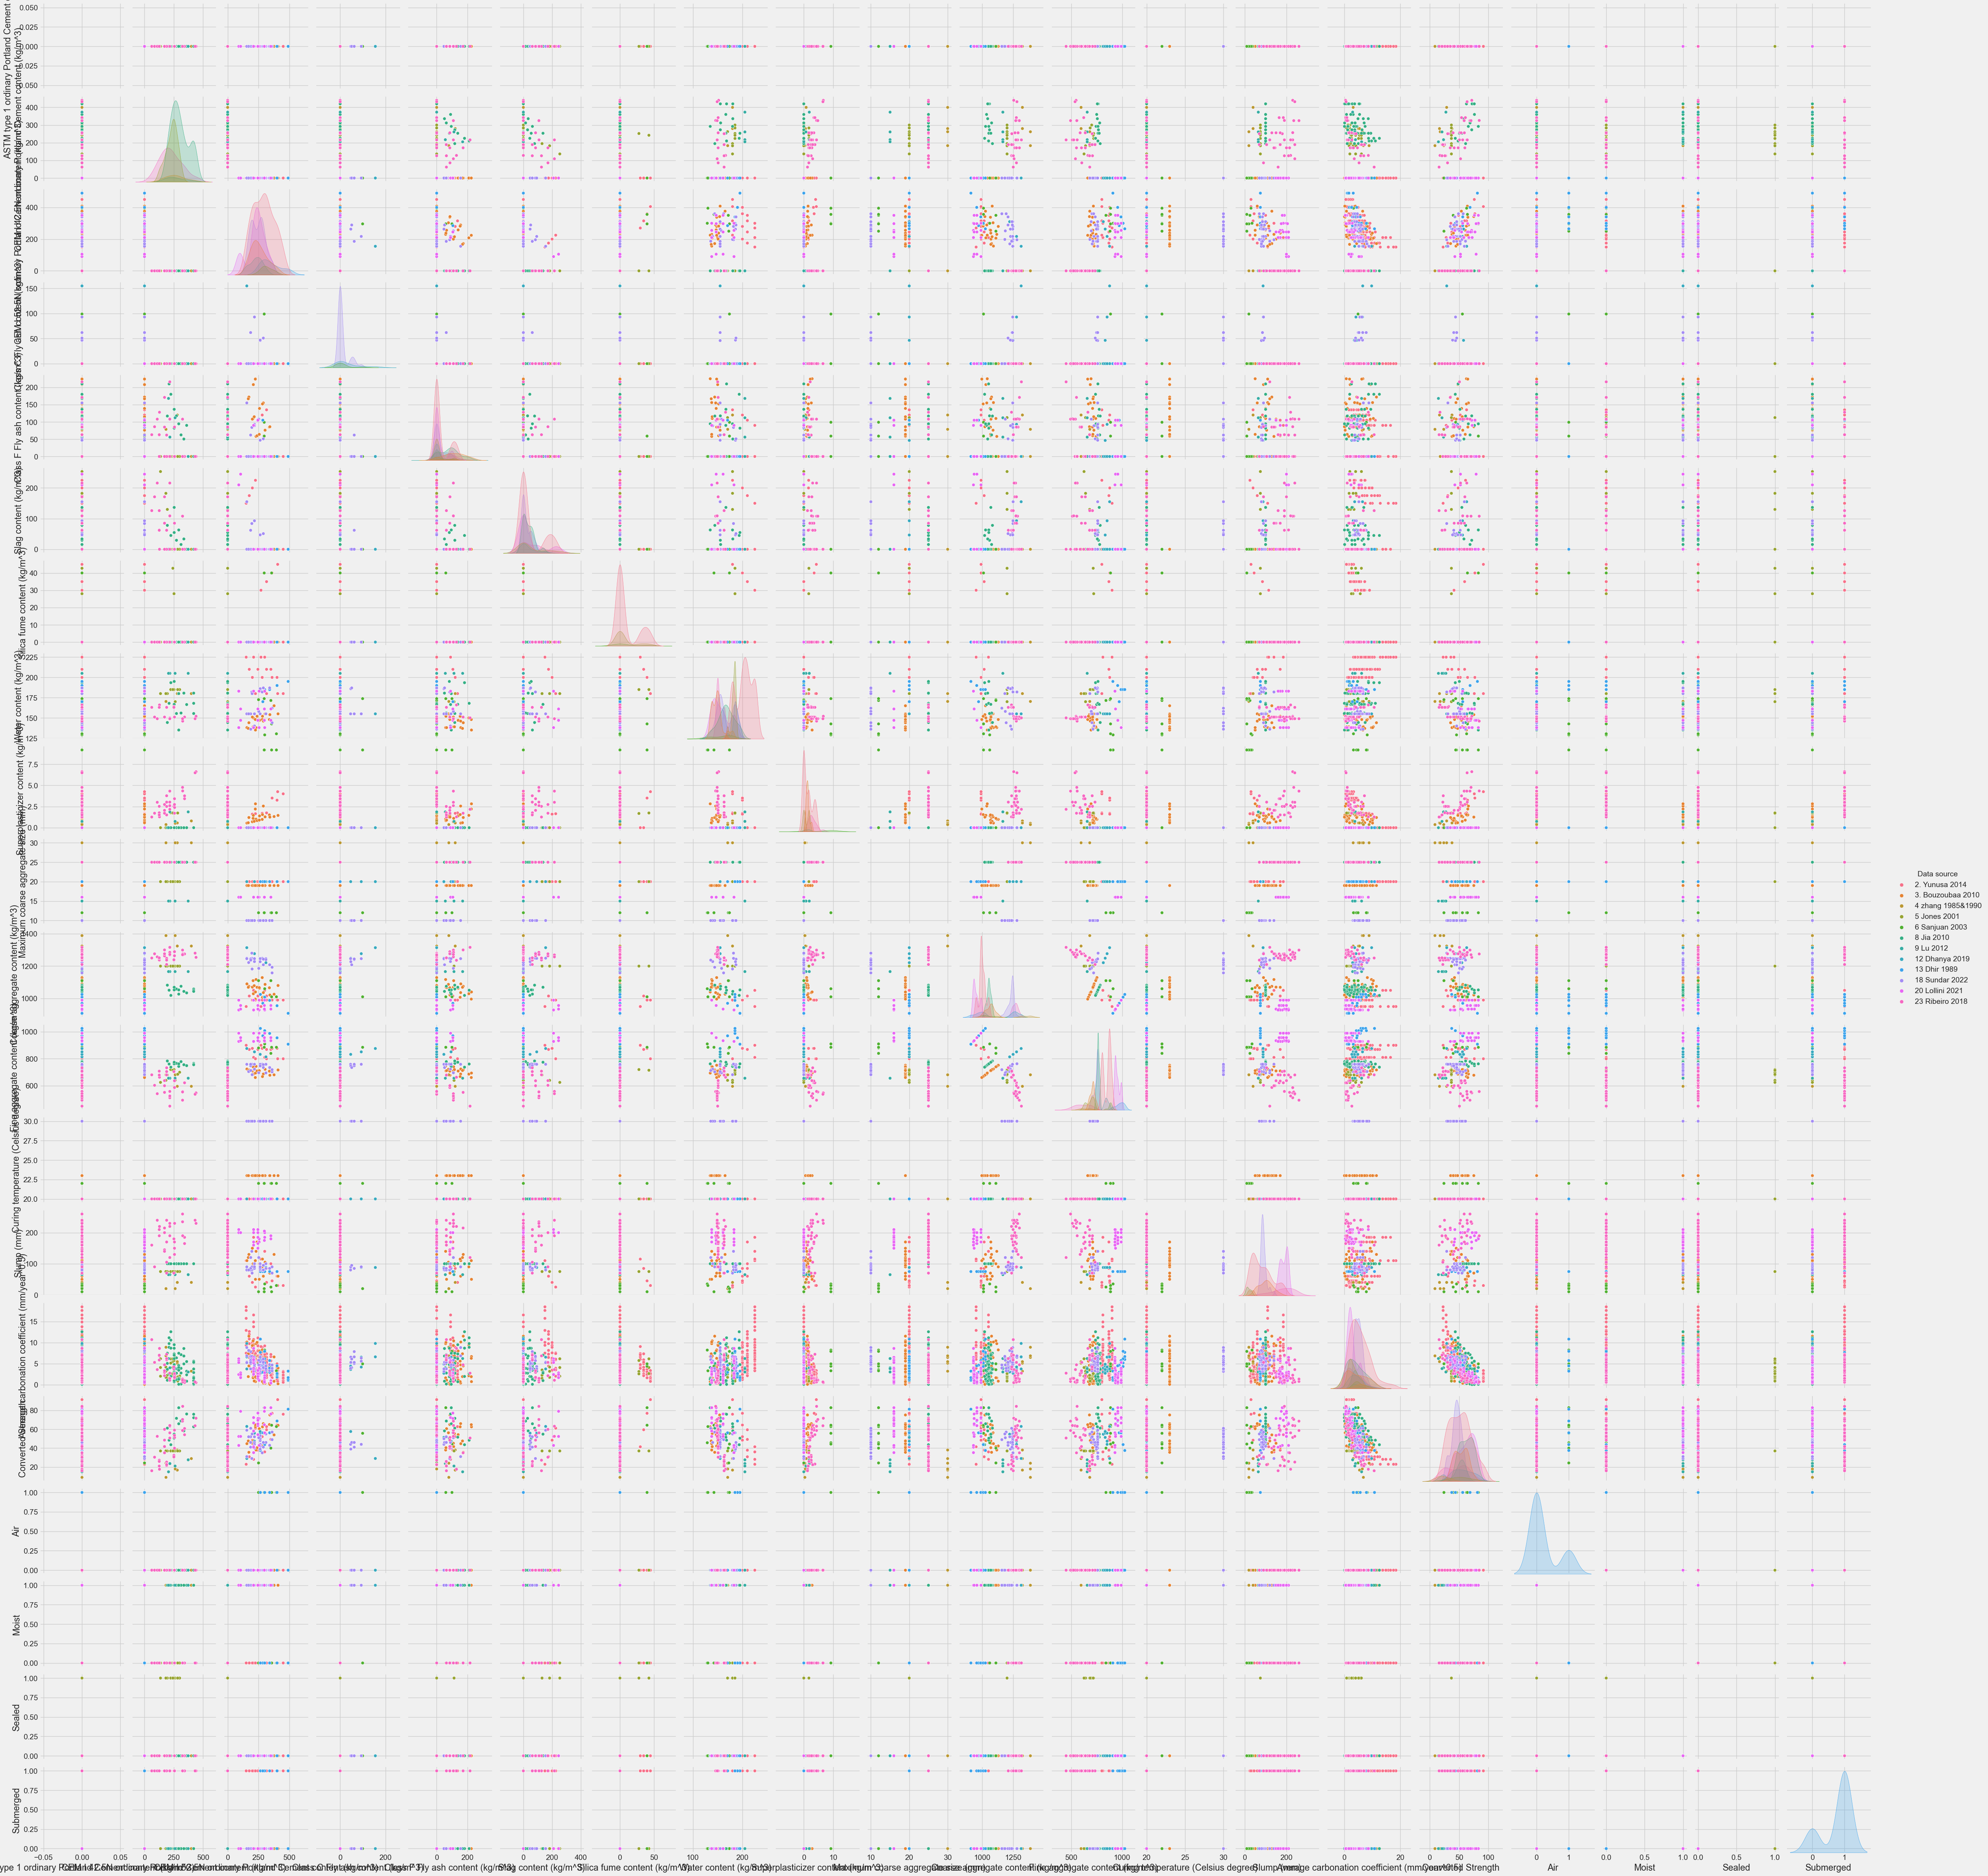

In [20]:
sns.pairplot(new_df_drop, hue= 'Data source', diag_kind= 'kde')
plt.show()

## Train test split

In [20]:
new_df_drop = new_df_drop.drop('Data source', axis = 1)

In [21]:
def get_outputs(df):
    y1 = df.pop('Slump (mm)')
    y1 = np.array(y1)
    
    y2 = df.pop('Average carbonation coefficient (mm/year^0.5)')
    y2 = np.array(y2)
    
    y3 = df.pop('Converted Strength')
    y3 = np.array(y3)
    
    return y1, y2, y3

In [22]:
big, test  =train_test_split(new_df_drop, test_size=0.1, random_state=42)
train, val = train_test_split(big, test_size=0.2, random_state=42)

In [23]:
# Getting the outputs Slump, Carbon coeff, and converted str of the train, validation, and test data
y_train = get_outputs(train)
y_val = get_outputs(val)
y_test = get_outputs(test)

## Min Max Scaler

In [24]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(train)
X_val = scaler.fit_transform(val)
X_test = scaler.fit_transform(test)

# Model evaluation

* RMSE, MAE, R2, Adjusted R2

# Model Building


In [25]:
backend.clear_session()
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [26]:
# Define input layer
input_layer = Input(shape = (17,), name = 'Input_layer')

# 3 hidden layers
layer_1 = Dense(128, activation = 'relu', name = 'Layer_1')(input_layer)
layer_2 = Dense(32,activation = 'relu', name = 'Layer_2')(layer_1)
layer_3 = Dense(16, activation = 'relu', name = 'Layer_3')(layer_2)

# Output layer y1 (Slump)
y1_output = Dense(1, activation = 'linear', name = 'Slump')(layer_3)

# Branched layer (Carbon coeff)
branch_1 = Dense(8, activation = 'relu', name = 'Carbon_coeff_branch')(layer_3)
# Output layer y2 (Carbon coeff)
y2_output = Dense(1, activation = 'linear', name = 'Carbon_coeff')(branch_1)

# Branched layer y3 (Compressive strength)
branch_2 = Dense(8, activation = 'relu', name = 'Comp_str_branch')(layer_3)
#Output layer y3 (Comp Str)
y3_output =  Dense(1, activation = 'linear', name = 'Comp_str')(branch_2)

# Define the model
model = Model(inputs = input_layer, outputs = [y1_output, y2_output, y3_output])

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_layer         │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Layer_1 (Dense)     │ (None, 128)       │      2,304 │ Input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Layer_2 (Dense)     │ (None, 32)        │      4,128 │ Layer_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Layer_3 (Dense)     │ (None, 16)        │        528 │ Layer_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Carbon_coeff_branch │ (None, 8)         │        136 │ Layer_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Comp_str_branch     │ (None, 8)         │        136 │ Layer_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Slump (Dense)       │ (None, 1)         │         17 │ Layer_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Carbon_coeff        │ (None, 1)         │          9 │ Carbon_coeff_bra… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Comp_str (Dense)    │ (None, 1)         │          9 │ Comp_str_branch[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,267 (28.39 KB)

 Trainable params: 7,267 (28.39 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
optimizer = Adam(learning_rate = 0.01)

model.compile(optimizer=optimizer,
              loss = {'Slump': 'mse', 'Carbon_coeff': 'mse', 'Comp_str': 'mse'},
              metrics = ['mse', 'mse', 'mse'])
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 100)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - Carbon_coeff_mse: 24.7112 - Comp_str_mse: 2619.3818 - Slump_mse: 13325.5703 - loss: 15879.6924 - val_Carbon_coeff_mse: 37.6383 - val_Comp_str_mse: 650.3887 - val_Slump_mse: 7386.7886 - val_loss: 8134.8081
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Carbon_coeff_mse: 36.0047 - Comp_str_mse: 1412.5192 - Slump_mse: 5148.3291 - loss: 6577.4644 - val_Carbon_coeff_mse: 53.6939 - val_Comp_str_mse: 256.6461 - val_Slump_mse: 2985.3557 - val_loss: 3327.4773
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Carbon_coeff_mse: 38.3417 - Comp_str_mse: 528.5128 - Slump_mse: 2818.2561 - loss: 3381.0701 - val_Carbon_coeff_mse: 29.0261 - val_Comp_str_mse: 282.1111 - val_Slump_mse: 3003.8674 - val_loss: 3346.9739
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Carbon_coeff_mse: 24.6996 - Comp_str_mse: 368.7310 - Slump_mse: 2384.6130 - loss: 2770.9644 - val_Carbon_coeff_mse: 28.1018 - val_Comp_str_mse: 347.5133 - val_Slump_mse: 2762.12

In [29]:
history.history.keys()

dict_keys(['Carbon_coeff_mse', 'Comp_str_mse', 'Slump_mse', 'loss', 'val_Carbon_coeff_mse', 'val_Comp_str_mse', 'val_Slump_mse', 'val_loss'])

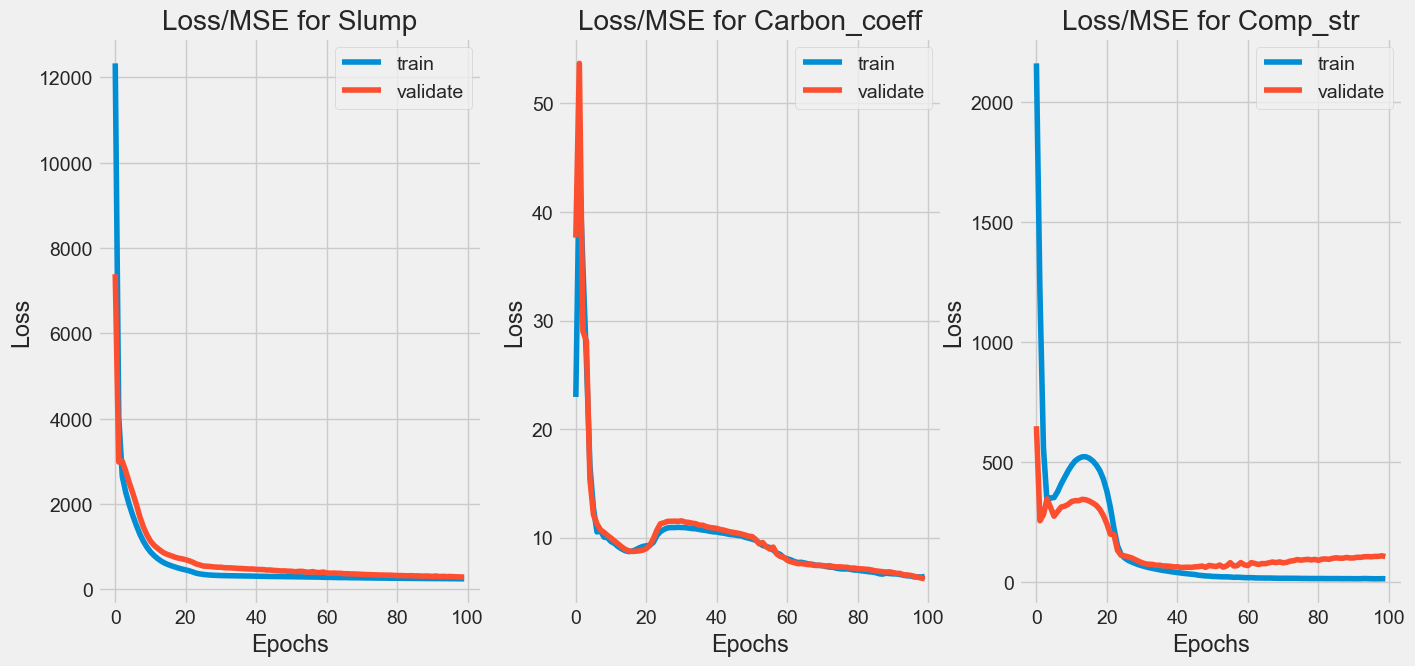

In [30]:
plt.figure(figsize=(15, 7))

# Plot Loss/MSE for Slump
plt.subplot(1, 3, 1)
plt.plot(history.history['Slump_mse'], label='train')
plt.plot(history.history['val_Slump_mse'], label='validate')
plt.title('Loss/MSE for Slump')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Loss/MSE for Carbon_coeff
plt.subplot(1, 3, 2)
plt.plot(history.history['Carbon_coeff_mse'], label='train')
plt.plot(history.history['val_Carbon_coeff_mse'], label='validate')
plt.title('Loss/MSE for Carbon_coeff')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Loss/MSE for Comp_str
plt.subplot(1, 3, 3)
plt.plot(history.history['Comp_str_mse'], label='train')
plt.plot(history.history['val_Comp_str_mse'], label='validate')
plt.title('Loss/MSE for Comp_str')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

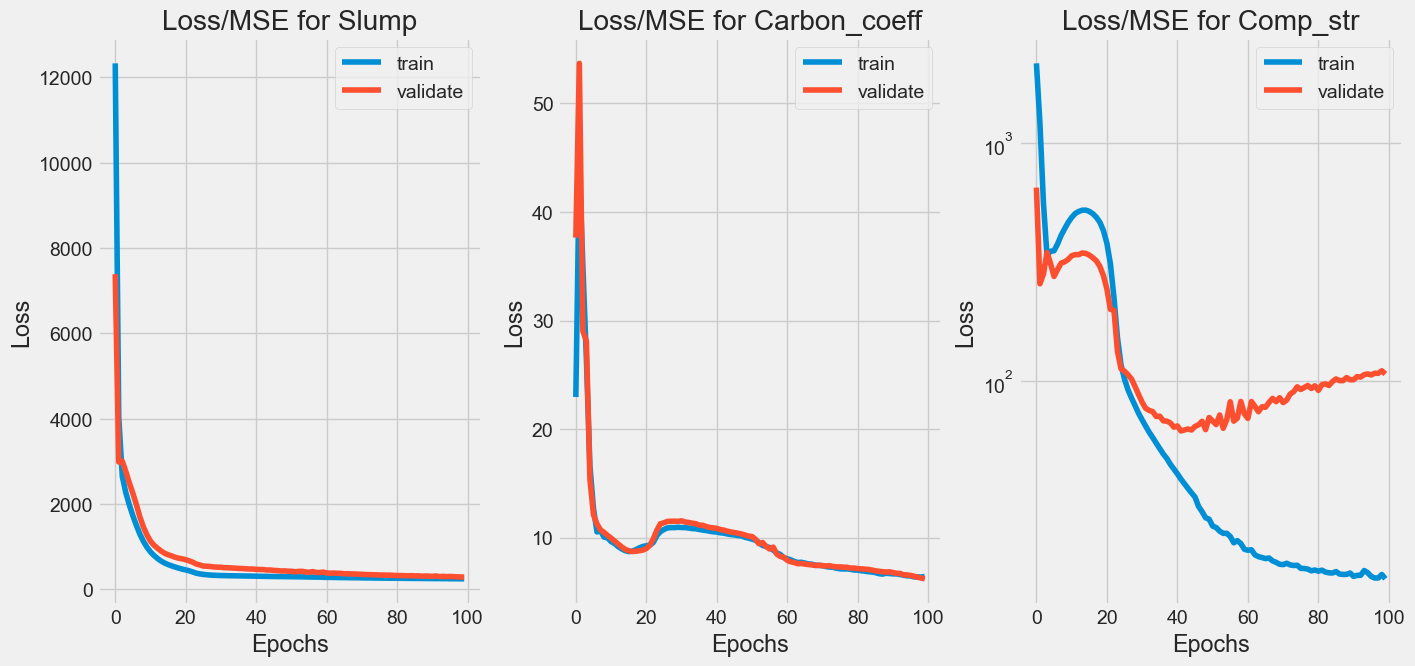

In [31]:
plt.figure(figsize=(15, 7))

# Plot Loss/MSE for Slump
plt.subplot(1, 3, 1)
plt.plot(history.history['Slump_mse'], label='train')
plt.plot(history.history['val_Slump_mse'], label='validate')
plt.title('Loss/MSE for Slump')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Loss/MSE for Carbon_coeff
plt.subplot(1, 3, 2)
plt.plot(history.history['Carbon_coeff_mse'], label='train')
plt.plot(history.history['val_Carbon_coeff_mse'], label='validate')
plt.title('Loss/MSE for Carbon_coeff')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Loss/MSE for Comp_str
plt.subplot(1, 3, 3)
plt.plot(history.history['Comp_str_mse'], label='train')
plt.plot(history.history['val_Comp_str_mse'], label='validate')
plt.title('Loss/MSE for Comp_str')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.yscale('log')
plt.show()

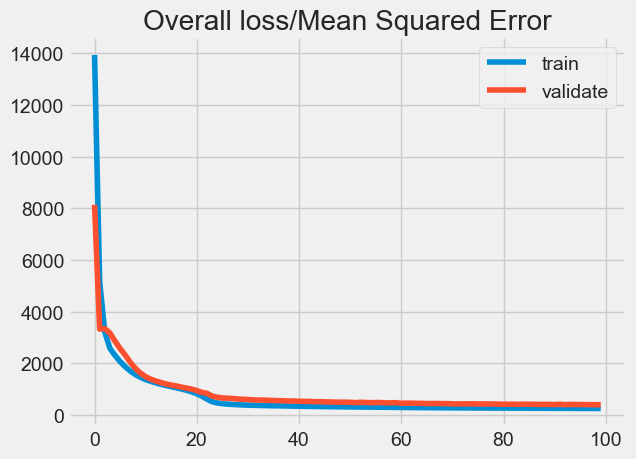

In [32]:
plt.title('Overall loss/Mean Squared Error')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validate')
plt.legend()
plt.show()

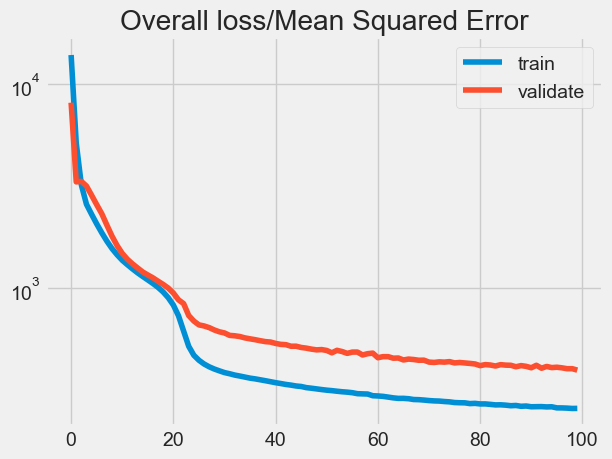

In [33]:
plt.title('Overall loss/Mean Squared Error')
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'validate')
plt.yscale('log')
plt.legend()
plt.show()

# Model Performance

## Validation performance

In [34]:
y_val_pred = model.predict(X_val)

# Convert tuples to numpy arrays
y_val = np.array(y_val)
y_val_pred = np.array(y_val_pred)

# Calculate and display overall validation performance metrics
overall_rmse = np.sqrt(mean_squared_error(y_val.flatten(), y_val_pred.flatten()))
overall_mae = mean_absolute_error(y_val.flatten(), y_val_pred.flatten())
overall_r2 = r2_score(y_val.flatten(), y_val_pred.flatten())
overall_adj_r2 = 1 - (1 - overall_r2) * (len(y_val.flatten()) - 1) / (len(y_val.flatten()) - X_val.shape[1] - 1)

# Create a dictionary to store the performance metrics
metrics = {
    'Metric': ['RMSE', 'MAE', 'R2', 'Adjusted R2'],
    'Overall Performance': [overall_rmse, overall_mae, overall_r2, overall_adj_r2]
}

# Create a DataFrame from the metrics dictionary
val_performance = pd.DataFrame(metrics)

# Display the DataFrame
val_performance

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Metric  Overall Performance
0         RMSE            11.569992
1          MAE             7.241003
2           R2             0.952512
3  Adjusted R2             0.949346

In [35]:
# Predict on the test set
y_test_pred = model.predict(X_test)

# Convert tuples to numpy arrays
y_test = np.array(y_test)
y_test_pred = np.array(y_test_pred)

# Calculate test set performance metrics
test_rmse = np.sqrt(mean_squared_error(y_test.flatten(), y_test_pred.flatten()))
test_mae = mean_absolute_error(y_test.flatten(), y_test_pred.flatten())
test_r2 = r2_score(y_test.flatten(), y_test_pred.flatten())
test_adj_r2 = 1 - (1 - test_r2) * (len(y_test.flatten()) - 1) / (len(y_test.flatten()) - X_test.shape[1] - 1)

# Create a dictionary to store the test set performance metrics
metrics_test = {
    'Metric': ['RMSE', 'MAE', 'R2', 'Adjusted R2'],
    'Test Performance': [test_rmse, test_mae, test_r2, test_adj_r2]
}

# Create a DataFrame for the test set performance metrics
test_performance = pd.DataFrame(metrics_test)

# Display the DataFrame
test_performance

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


Metric  Test Performance
0         RMSE         12.629723
1          MAE          6.469664
2           R2          0.948319
3  Adjusted R2          0.941811

In [36]:
y_test_pred

array([[[ 61.748558 ],
        [ 94.19575  ],
        [141.55025  ],
        [ 26.938972 ],
        [ 75.46053  ],
        [ 29.457193 ],
        [200.2739   ],
        [ 29.457193 ],
        [199.41275  ],
        [158.4778   ],
        [ 93.93442  ],
        [ 40.6811   ],
        [230.10806  ],
        [ 85.95561  ],
        [ 76.42943  ],
        [ 69.53599  ],
        [ 29.457193 ],
        [ 74.196075 ],
        [ 73.48708  ],
        [200.0955   ],
        [ 91.88063  ],
        [ 87.74968  ],
        [ 85.95561  ],
        [156.93558  ],
        [203.82141  ],
        [203.82141  ],
        [120.99365  ],
        [ 69.53599  ],
        [ 96.41502  ],
        [181.40234  ],
        [ 72.961174 ],
        [176.36627  ],
        [ 80.528366 ],
        [ 74.04619  ],
        [128.9384   ],
        [ 48.786255 ],
        [101.70033  ],
        [ 73.97909  ],
        [ 93.93442  ],
        [ 40.6811   ],
        [124.63191  ],
        [174.695    ],
        [ 69.44334  ],
        [ 3

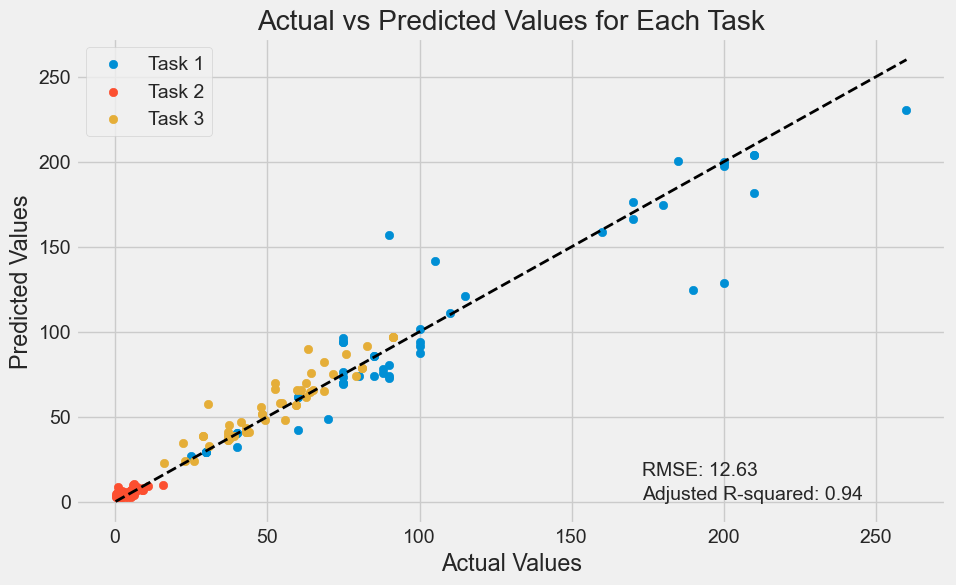

In [37]:
# Plotting the predicted values against the actual values for each task
plt.figure(figsize=(10, 6))
for i in range(y_test.shape[0]):
    plt.scatter(y_test[i, :], y_test_pred[i, :], label=f"Task {i+1}")

# Plotting the diagonal line indicating correct prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Setting plot labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Each Task")
plt.legend(loc='upper left')

# Adding RMSE and Adjusted R-squared as text annotations
plt.text(0.65, 0.1, f"RMSE: {test_rmse:.2f}", transform=plt.gca().transAxes)
plt.text(0.65, 0.05, f"Adjusted R-squared: {test_adj_r2:.2f}", transform=plt.gca().transAxes)

# Display the plot
plt.show()

In [102]:
# Assuming y_test and y_test_pred are arrays containing true and predicted values for each task
task_rmse = []
task_adj_r2 = []

# Calculate RMSE and Adjusted R-squared for each task
for i in range(len(y_test)):
    # Calculate RMSE
    rmse = mean_squared_error(y_test[i], y_test_pred[i], squared=False)
    task_rmse.append(rmse)

    # Calculate R-squared
    r2 = r2_score(y_test[i], y_test_pred[i])

    # Get the number of samples (n) and number of predictors (k)
    n = len(y_test[i])
    k = X_test.shape[1]  # Assuming X_test is your feature matrix

    # Calculate adjusted R-squared
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))
    task_adj_r2.append(adj_r2)

# Print or use task_rmse and task_adj_r2 as needed
for i in range(len(task_rmse)):
    print(f"Task {i+1} - RMSE: {task_rmse[i]:.2f}, Adjusted R-squared: {task_adj_r2[i]:.2f}")

Task 1 - RMSE: 20.15, Adjusted R-squared: 0.83
Task 2 - RMSE: 2.51, Adjusted R-squared: 0.02
Task 3 - RMSE: 8.14, Adjusted R-squared: 0.72


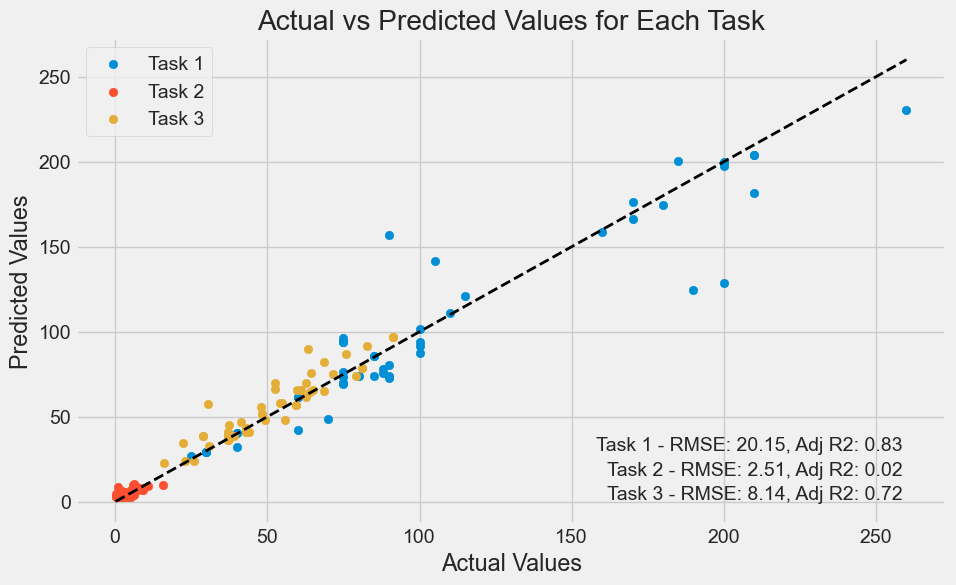

In [108]:
# Plotting the predicted values against the actual values for each task
plt.figure(figsize=(10, 6))
for i in range(y_test.shape[0]):
    plt.scatter(y_test[i, :], y_test_pred[i, :], label=f"Task {i+1}")

# Plotting the diagonal line indicating correct prediction
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Setting plot labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values for Each Task")
plt.legend(loc='upper left')

# Specify the order of tasks
task_order = [2, 1, 0]  # Assuming task 3 is index 0, task 2 is index 1, and task 1 is index 2

# Annotating the plot with RMSE and Adjusted R-squared for each task
for i, task_index in enumerate(task_order):
    plt.text(0.95, 0.05 + i * 0.05, f"Task {task_index + 1} - RMSE: {task_rmse[task_index]:.2f}, Adj R2: {task_adj_r2[task_index]:.2f}", transform=plt.gca().transAxes, ha='right')

# Display the plot
plt.show()

# Prediction on the lab data 

In [85]:
lab = pd.read_excel('28dCompressiveResults_2_reworked.xlsx')
lab

No.       Mix No.  Cementitious materials\n(kg/m3)  OPC\n(kg/m3)  Type  \
0     1    FA-0.45-12                       400.000000    352.000000    FA   
1     2    SF-0.35-10                       497.142857    447.428571    SF   
2     3  GGBS-0.45-25                       400.000000    300.000000  GGBS   
3     4     SF-0.55-5                       334.545455    317.818182    SF   
4     5    SF-0.45-10                       400.000000    360.000000    SF   
5     6    FA-0.45-25                       400.000000    300.000000    FA   
6     7     SF-0.35-5                       497.142857    472.285714    SF   
7     8    FA-0.35-25                       497.142857    372.857143    FA   
8     9    FA-0.55-40                       334.545455    200.727273    FA   
9    10  GGBS-0.45-50                       400.000000    200.000000  GGBS   
10   11    SF-0.55-15                       334.545455    284.363636    SF   
11   12  GGBS-0.35-25                       497.142857    372.857143  GGBS   
12   13    FA-0.55-25                       334.545455    250.909091    FA   
13   14    FA-0.35-12                       497.142857    437.485714    FA   
14   15    FA-0.55-12                       334.545455    294.400000    FA   
15   16  GGBS-0.35-75                       497.142857    124.285714  GGBS   
16   17  GGBS-0.55-50                       334.545455    167.272727  GGBS   
17   18    SF-0.45-15                       400.000000    340.000000    SF   
18   19    SF-0.35-15                       497.142857    422.571429    SF   
19   20    FA-0.45-40                       400.000000    240.000000    FA   
20   21  GGBS-0.35-50                       497.142857    248.571429  GGBS   
21   22    SF-0.55-10                       334.545455    301.090909    SF   
22   23    FA-0.35-40                       497.142857    298.285714    FA   
23   24  GGBS-0.55-25                       334.545455    250.909091  GGBS   
24   25  GGBS-0.45-75                       400.000000    100.000000  GGBS   
25   26     SF-0.45-5                       400.000000    380.000000    SF   
26   27  GGBS-0.55-75                       334.545455     83.636364  GGBS   

    Replacement level (%)  Content\n(kg/m3)  Aggregate proportion  \
0                      12         48.000000              0.759834   
1                      10         49.714286              0.722997   
2                      25        100.000000              0.759834   
3                       5         16.727273              0.784814   
4                      10         40.000000              0.759834   
5                      25        100.000000              0.759834   
6                       5         24.857143              0.722997   
7                      25        124.285714              0.722997   
8                      40        133.818182              0.784814   
9                      50        200.000000              0.759834   
10                     15         50.181818              0.784814   
11                     25        124.285714              0.722997   
12                     25         83.636364              0.784814   
13                     12         59.657143              0.722997   
14                     12         40.145455              0.784814   
15                     75        372.857143              0.722997   
16                     50        167.272727              0.784814   
17                     15         60.000000              0.759834   
18                     15         74.571429              0.722997   
19                     40        160.000000              0.759834   
20                     50        248.571429              0.722997   
21                     10         33.454545              0.784814   
22                     40        198.857143              0.722997   
23                     25         83.636364              0.784814   
24                     75        300.000000              0.759834   
25                      5

# Data cleaning

In [86]:
data = lab.copy()
data = data.drop(['No.', 'Mix No.', 'Replacement level (%)', 'Cementitious materials\n(kg/m3)',
                  '20mm\n(kg/m3)', '10mm\n(kg/m3)', 'Aggregate proportion', 'Fine aggregate proportion',
                  ], axis= 1)

data['ASTM type 1 ordinary Portland Cement content (kg/m^3)'] = 0
data['CEM I 52.5N ordinary Portland Cement content (kg/m^3)'] = 0
data['Class C Fly ash content (kg/m^3)'] = 0
data  = data.rename(columns = {'OPC\n(kg/m3)': 'CEM I 42.5N ordinary Portland Cement content (kg/m^3)',
                               'Fine\n(kg/m3)': 'Fine aggregate content (kg/m^3)',
                               'Water\n(kg/m3)': 'Water content (kg/m^3)',
                               'SP\n(L/m3)': 'Superplasticizer content (kg/m^3)',
                               'Compressive strength\n(MPa)': 'Converted Strength'})

data['Coarse aggregate content (kg/m^3)'] = data['Aggregate content\n(kg/m3)'] - data['Fine aggregate content (kg/m^3)']
data = data.drop(['Aggregate content\n(kg/m3)'], axis=1)
data['Maximum coarse aggregate size (mm)'] = 20
data['Curing temperature (Celsius degree)'] = 20

## Type

In [87]:

data_pivot = pd.pivot_table(data, index=data.index,
                            columns='Type',
                            values='Content\n(kg/m3)',
                            aggfunc='first',
                            fill_value=0)

# Rename the columns
data_pivot.rename(columns={'FA': 'Class F Fly ash content (kg/m^3)',
                           'SF': 'Silica fume content (kg/m^3)',
                           'GGBS': 'Slag content (kg/m^3)'},
                  inplace=True)

# Merge the new columns with the original DataFrame
data = pd.concat([data, data_pivot], axis=1)

# Drop the 'Type' column
data.drop(['Type', 'Content\n(kg/m3)'], axis=1, inplace=True)

## Reorder

In [88]:
desired_order = [
    'ASTM type 1 ordinary Portland Cement content (kg/m^3)',
    'CEM I 42.5N ordinary Portland Cement content (kg/m^3)',
    'CEM I 52.5N ordinary Portland Cement content (kg/m^3)',
    'Class C Fly ash content (kg/m^3)',
    'Class F Fly ash content (kg/m^3)',
    'Slag content (kg/m^3)',
    'Silica fume content (kg/m^3)',
    'Water content (kg/m^3)',
    'Superplasticizer content (kg/m^3)',
    'Maximum coarse aggregate size (mm)',
    'Coarse aggregate content (kg/m^3)',
    'Fine aggregate content (kg/m^3)',
    'Curing method',
    'Curing temperature (Celsius degree)',
    'Converted Strength'
]

data = data.reindex(columns=desired_order)
data

ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
0                                                   0       
1                                                   0       
2                                                   0       
3                                                   0       
4                                                   0       
5                                                   0       
6                                                   0       
7                                                   0       
8                                                   0       
9                                                   0       
10                                                  0       
11                                                  0       
12                                                  0       
13                                                  0       
14                                                  0       
15                                                  0       
16                                                  0       
17                                                  0       
18                                                  0       
19                                                  0       
20                                                  0       
21                                                  0       
22                                                  0       
23                                                  0       
24                                                  0       
25                                                  0       
26                                                  0       

    CEM I 42.5N ordinary Portland Cement content (kg/m^3)  \
0                                          352.000000       
1                                          447.428571       
2                                          300.000000       
3                                          317.818182       
4                                          360.000000       
5                                          300.000000       
6                                          472.285714       
7                                          372.857143       
8                                          200.727273       
9                                          200.000000       
10                                         284.363636       
11                                         372.857143       
12                                         250.909091       
13                                         437.485714       
14                                         294.400000       
15                                         124.285714       
16                                         167.272727       
17                                         340.000000       
18                                         422.571429       
19                                         240.000000       
20                                         248.571429       
21                                         301.090909       
22                                         298.285714       
23                                         250.909091       
24                                         100.000000       
25                                         380.000000       
26                                          83.636364       

    CEM I 52.5N ordinary Portland Cement content (kg/m^3)  \
0                                                   0       
1                                                   0       
2                                                   0       
3                                                   0       
4                                                   0       
5                                                   0       
6                                                   0       
7                                                   0       
8                                    

# Curing method

In [89]:
data = pd.concat([data, pd.get_dummies(data['Curing method'])], axis=1)
data['Moist'] = 0

In [90]:
data.drop('Curing method', axis=1, inplace= True)
data

ASTM type 1 ordinary Portland Cement content (kg/m^3)  \
0                                                   0       
1                                                   0       
2                                                   0       
3                                                   0       
4                                                   0       
5                                                   0       
6                                                   0       
7                                                   0       
8                                                   0       
9                                                   0       
10                                                  0       
11                                                  0       
12                                                  0       
13                                                  0       
14                                                  0       
15                                                  0       
16                                                  0       
17                                                  0       
18                                                  0       
19                                                  0       
20                                                  0       
21                                                  0       
22                                                  0       
23                                                  0       
24                                                  0       
25                                                  0       
26                                                  0       

    CEM I 42.5N ordinary Portland Cement content (kg/m^3)  \
0                                          352.000000       
1                                          447.428571       
2                                          300.000000       
3                                          317.818182       
4                                          360.000000       
5                                          300.000000       
6                                          472.285714       
7                                          372.857143       
8                                          200.727273       
9                                          200.000000       
10                                         284.363636       
11                                         372.857143       
12                                         250.909091       
13                                         437.485714       
14                                         294.400000       
15                                         124.285714       
16                                         167.272727       
17                                         340.000000       
18                                         422.571429       
19                                         240.000000       
20                                         248.571429       
21                                         301.090909       
22                                         298.285714       
23                                         250.909091       
24                                         100.000000       
25                                         380.000000       
26                                          83.636364       

    CEM I 52.5N ordinary Portland Cement content (kg/m^3)  \
0                                                   0       
1                                                   0       
2                                                   0       
3                                                   0       
4                                                   0       
5                                                   0       
6                                                   0       
7                                                   0       
8                                    

In [91]:
order  = ['ASTM type 1 ordinary Portland Cement content (kg/m^3)',
          'CEM I 42.5N ordinary Portland Cement content (kg/m^3)',
          'CEM I 52.5N ordinary Portland Cement content (kg/m^3)',
          'Class C Fly ash content (kg/m^3)', 'Class F Fly ash content (kg/m^3)',
          'Slag content (kg/m^3)', 'Silica fume content (kg/m^3)',
          'Water content (kg/m^3)', 'Superplasticizer content (kg/m^3)',
          'Maximum coarse aggregate size (mm)',
          'Coarse aggregate content (kg/m^3)', 'Fine aggregate content (kg/m^3)',
          'Curing temperature (Celsius degree)', 'Air', 'Moist', 'Sealed',
          'Submerged', 'Converted Strength']
data = data.reindex(columns = order)

X = data.drop('Converted Strength', axis = 1)
X_lab = scaler.transform(X)
y_lab = data['Converted Strength']

In [92]:
lab_pred = model.predict(X_lab)
lab_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


[array([[114.90498 ],
        [ 74.648026],
        [112.436676],
        [104.87253 ],
        [179.51611 ],
        [233.39096 ],
        [103.113144],
        [ 99.07968 ],
        [113.92361 ],
        [161.87048 ],
        [ 87.30847 ],
        [100.33148 ],
        [ 94.88846 ],
        [132.7403  ],
        [116.70328 ],
        [ 68.47401 ],
        [ 43.675934],
        [ 37.543564],
        [110.98518 ],
        [ 41.84353 ],
        [105.98949 ],
        [ 50.10148 ],
        [139.64015 ],
        [ 92.87805 ],
        [ 67.40228 ],
        [102.4932  ],
        [ 93.3815  ]], dtype=float32),
 array([[ 4.610074 ],
        [ 3.099634 ],
        [ 5.681872 ],
        [10.405734 ],
        [ 5.593465 ],
        [ 8.5610695],
        [ 4.5962963],
        [ 2.5247617],
        [ 2.9386053],
        [ 6.19699  ],
        [ 4.5356917],
        [ 4.859541 ],
        [ 7.6537566],
        [ 4.1660886],
        [10.507376 ],
        [ 5.2826123],
        [ 7.8886247],
        [ 5.733

In [94]:
str_pred = lab_pred[2]
str_pred

array([[ 67.9987  ],
       [106.92372 ],
       [ 55.235497],
       [ 60.921803],
       [ 99.52615 ],
       [ 40.726284],
       [ 67.773544],
       [ 97.622955],
       [ 33.194447],
       [ 71.30985 ],
       [ 64.59553 ],
       [ 48.88664 ],
       [ 19.08705 ],
       [ 59.366104],
       [ 59.223015],
       [ 93.21768 ],
       [ 18.01842 ],
       [ 64.492325],
       [150.77917 ],
       [ 45.882313],
       [ 84.981285],
       [ 36.553387],
       [ 75.083206],
       [ 53.37627 ],
       [ 46.671467],
       [ 61.59051 ],
       [ 32.405434]], dtype=float32)

In [100]:
lab_df = pd.DataFrame({'True Values': y_lab, 'Predicted Values': str_pred.flatten()})
lab_df

True Values  Predicted Values
0        56.800         67.998703
1        76.205        106.923721
2        36.500         55.235497
3        55.190         60.921803
4        76.010         99.526154
5        68.200         40.726284
6        75.355         67.773544
7        76.050         97.622955
8        44.150         33.194447
9        52.700         71.309853
10       65.350         64.595528
11       61.500         48.886639
12       45.250         19.087049
13       82.600         59.366104
14       51.500         59.223015
15       46.200         93.217682
16       43.700         18.018419
17       75.175         64.492325
18       81.765        150.779175
19       49.900         45.882313
20       63.100         84.981285
21       58.015         36.553387
22       64.250         75.083206
23       28.700         53.376270
24       41.800         46.671467
25       65.915         61.590511
26       43.600         32.405434

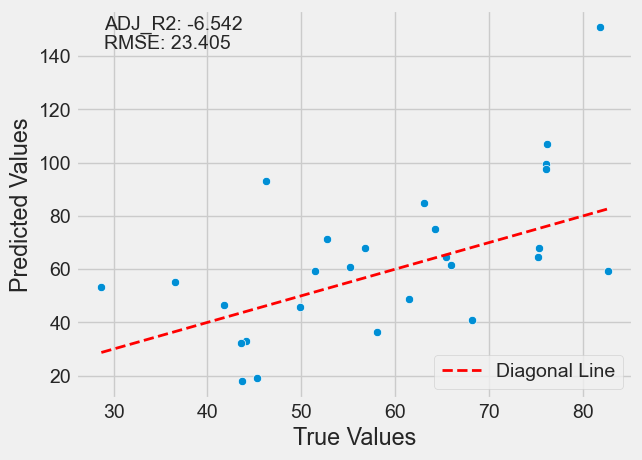

In [101]:
r2 = r2_score(lab_df['True Values'], lab_df['Predicted Values'])
# Get the number of samples (n) and number of predictors (k)
n = len(lab_df)
k = X.shape[1]  # Assuming X is your feature matrix

# Calculate adjusted R-squared
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

rmse = mean_squared_error(lab_df['True Values'], lab_df['Predicted Values'], squared=False)

# Create the lmplot
sns.scatterplot(data=lab_df,x='True Values', y='Predicted Values' )

# Add a diagonal line for correct predictions (x = y)
plt.plot([lab_df['True Values'].min(), lab_df['True Values'].max()],
         [lab_df['True Values'].min(), lab_df['True Values'].max()],
         linestyle='--', label='Diagonal Line', lw=2, color='red')

# Annotate the plot with R2 and RMSE
plt.text(0.05, 0.95, f'ADJ_R2: {adj_r2:.3f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.9, f'RMSE: {rmse:.3f}', transform=plt.gca().transAxes)

plt.legend(loc='lower right')
# Display the plot
plt.show()